# Modelling

The objective fo this notebook is to utilize some methods to find and determine the optimal model to solve the challenge problem. 

## Libraries

In [1]:
import numpy as np 
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
from cnr_methods import get_selected_features, transform_data, revert_data,metric_cnr, get_simplified_data
import tsfresh


from sklearn.model_selection import TimeSeriesSplit, train_test_split
from collections import deque
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import xgboost as xgb

## Read Data

Here, the data used correspond to the results of the Feature Engineering and Selection Step. For simplicity, during Hyperparameter Optimization, only Wind Farm 1 Training Data is used.

In [2]:
full_data = get_selected_features(0)

#full_data = full_data.rename({'Unnamed: 0' : 'Time'},axis=1)
full_data = full_data.set_index('Time')


full_label = pd.read_csv('Data/Y_train.csv')
X = full_data[full_data['Set']=='Train']

WF = 'WF3'
X = X[X['WF']==WF]
y = full_label[full_label['ID'].isin(X['ID'])]

In [3]:
X = X.drop(['ID','WF','Set'],axis=1)

Here, differentiation (numpy.diff) is applied to the data, before the model is trained.

In [4]:
#X = transform_data(X)

## Validation Scheme

Before proceeding to the Hyperparameter search, it is necessary first to have some way to reliably measure the performance of the model. For this purpose, it will be used a Time Split Cross Validation Method, were the "Test" Fold for each Iteration is going to be used as the Validation Data, and so, to make Early Stopping on the data.

In [5]:
k_fold_splits = 5
num_boost_round = 500
early_stopping_rounds = 50

In [6]:
def gpu_df(df,y):
    gpu_matrix = cp.asarray(df)
    gpu_matrix = xgb.DMatrix(gpu_matrix,label=y)
    return gpu_matrix

In [8]:
def objective(param,k_fold_splits=k_fold_splits,num_boost_round=num_boost_round,early_stopping_rounds=early_stopping_rounds):
    # Define Time Split Cross Validation
    tscv = TimeSeriesSplit(n_splits=k_fold_splits)

    # Separating Data from Hold Out Set

    X_cv, _, y_cv, _ = train_test_split(X, y, test_size=0.125, shuffle=False)

    # Set XGBoost for GPU
    param['tree_method'] = 'gpu_hist'

    train_scores = np.empty(0)
    val_scores = np.empty(0)
    test_scores = np.empty(0)
    for train_index, test_index in tscv.split(X_cv):

        # Get the Data of the Split
        X_train, X_test = X_cv.iloc[train_index], X_cv.iloc[test_index]
        y_train, y_test = y_cv.iloc[train_index], y_cv.iloc[test_index]

        # Separating Training Set of Split on Train and Validation Subsets
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

        # Apply GPU-DF Transformation
        dtrain = gpu_df(X_train,y_train['Production'])
        dval = gpu_df(X_val,y_val['Production'])
        dtest = gpu_df(X_test,y_test['Production'])

        # Train the Model
        progress = dict()
        watchlist = [(dtrain,'train'),(dval,'eval')]
        bst = xgb.train(param, dtrain, num_boost_round=num_boost_round, evals=watchlist, feval=metric_cnr,early_stopping_rounds=early_stopping_rounds,verbose_eval=False,evals_result=progress)

        # Train and Validation Score
        train_score = np.array(progress['train']['CAPE']).mean()
        val_score = np.array(progress['eval']['CAPE']).mean()

        # Test Score
        preds = bst.predict(dtest,ntree_limit=bst.best_ntree_limit)
        test_score = metric_cnr(preds,dtest)

        train_scores = np.append(train_scores,train_score)
        val_scores = np.append(val_scores,val_score)
        test_scores = np.append(test_scores,test_score[1])

    return {'loss' : test_scores.mean(), 'params' : param, 'status' : STATUS_OK, 'train_loss' : train_scores.mean(), 'val_loss' : val_scores.mean(), 'test_score_array' : test_scores}

In [9]:
# [Test] Objective Function with Train, Validation and Test Sets Only (No CV, Not being used at the Moment)

def objective_2(param,k_fold_splits=k_fold_splits,num_boost_round=num_boost_round,early_stopping_rounds=early_stopping_rounds):
    # Define Time Split Cross Validation
    tscv = TimeSeriesSplit(n_splits=k_fold_splits)

    # Separating Data from Hold Out Set
    X_cv, X_hold, y_cv, y_hold = train_test_split(X, y, test_size=0.125, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size=0.125, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, shuffle=False)

    # Apply GPU-DF Transformation
    dtrain = gpu_df(X_train,y_train['Production'])
    dval = gpu_df(X_val,y_val['Production'])
    dtest = gpu_df(X_test,y_test['Production'])

    # Set XGBoost for GPU
    param['tree_method'] = 'gpu_hist'

    progress = dict()
    watchlist = [(dtrain,'train'),(dval,'eval')]
    bst = xgb.train(param, dtrain, num_boost_round=num_boost_round, evals=watchlist, feval=metric_cnr,early_stopping_rounds=early_stopping_rounds,verbose_eval=False,evals_result=progress)

    # Train and Validation Score
    train_score = np.array(progress['train']['CAPE']).mean()
    val_score = np.array(progress['eval']['CAPE']).mean()

    # Test Score
    preds = bst.predict(dtest,ntree_limit=bst.best_ntree_limit)
    test_score = metric_cnr(preds,dtest)

    return {'loss' : test_score[1], 'params' : param, 'status' : STATUS_OK, 'train_loss' : train_score, 'val_loss' : val_score}

## Hyperparameter Tuning

For the Hyperparameter Tuning, the HyperOpt Library will be used, which implements some techniques for a more efficient search for parameters.

### Domain Space

Here, the Domain Space which will be searched is defined.

In [10]:
space = {
    'max_depth' : hp.choice('max_depth', np.arange(1,20,dtype=int)),
    'subsample' : hp.uniform('subsample', 0, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0, 1),
    'min_child_weight' : hp.uniform('min_child_weight', 0, 1000),
    'lambda' : hp.uniform('lambda', 500, 1000),
    'alpha' : hp.uniform('alpha', 0, 100),
    'eta' : hp.uniform('eta', 0, 5)
}

### Optimization Algorithm

Here, the Optimization Method is selected, and a Trials Object, used for get acess to info from the Optimzation Trails, is defined. Here the Tree of Parzen Estimators (TPE) is selected for the Optimization Method.

In [11]:
tpe_algorithm = tpe.suggest
bayes_trials = Trials()

### Bayesian Optimization

Here, the Optimization is properly run.

In [12]:
MAX_EVALS = 100

In [13]:
best = fmin(fn = objective_2, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

100%|██████████| 100/100 [02:49<00:00,  1.70s/trial, best loss: 32.96757425787589]


### Hold Out Score

Here, the best model selected by HyperOpt is applied to a Holdout Set, which occurs right after the data used in CV.

In [14]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.125, shuffle=False)
#X_holdout = transform_data(X_holdout)
dhold = gpu_df(X_holdout,y_holdout['Production'])

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

#X_train = transform_data(X_train)
#X_val = transform_data(X_val)

dtrain = gpu_df(X_train,y_train['Production'])
dval = gpu_df(X_val,y_val['Production'])

In [16]:

best = {'alpha': 31.900831462840383,
        'colsample_bylevel': 0.3684140632736379,
        'colsample_bytree': 0.9204134654027759,
        'eta': 0.1, #1.071575096497831
        'lambda': 500, #46.738461107650394
        'max_depth': 10,
        'min_child_weight': 171.325997666389,
        'subsample': 0.9553482889926606,
        'validate_parameters': 1}


In [17]:
progress = dict()
watchlist = [(dtrain,'train'),(dval,'eval')]
bst = xgb.train(best, dtrain, num_boost_round=num_boost_round, evals=watchlist, feval=metric_cnr,early_stopping_rounds=early_stopping_rounds,verbose_eval=False,evals_result=progress)

In [18]:
preds = bst.predict(dhold,ntree_limit=bst.best_ntree_limit)
preds = np.clip(preds,0,None)
score = metric_cnr(preds,dhold)

The Score for the HoldOut Set is shown here.

In [19]:
print(score)

('CAPE', 34.02132326296952)


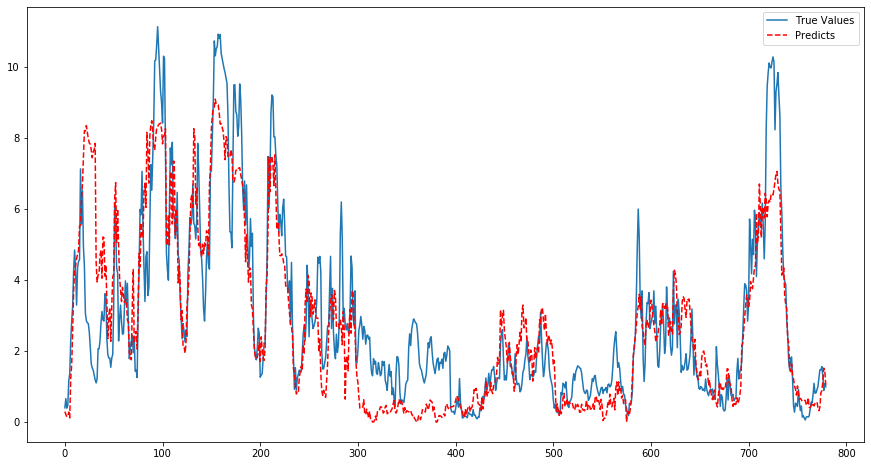

In [20]:
plt.figure(figsize=(15,8))
preds_len = np.arange(len(dhold.get_label()))
plt.plot(preds_len,dhold.get_label(),label='True Values')
plt.plot(preds_len,preds,'r--',label='Predicts')
plt.legend()

## Generating Predictions

Finally, the best model selected is applied to all Wind Farms separately, using all Training Data for Training and Predicting all the Test Data at once (At least for the moment).

In [22]:
best

{'alpha': 47.365945885516496,
 'colsample_bylevel': 0.8268093515276321,
 'colsample_bytree': 0.6198387782171412,
 'eta': 0.22591192615818248,
 'lambda': 615.7358656087586,
 'max_depth': 1,
 'min_child_weight': 113.63130171634668,
 'subsample': 0.9745157354310129,
 'validate_parameters': 1}

In [23]:
preds = []
for WF in full_data['WF'].unique():
    X_WF = full_data[full_data['WF']==WF]
    X_train = X_WF[X_WF['Set']=='Train']
    y_train = full_label[full_label['ID'].isin(X_train['ID'])]

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

    X_test = X_WF[X_WF['Set']=='Test']

    #Transform Data
    #X_train = transform_data(X_train.drop(['ID','WF','Set'],axis=1))
    #X_test = transform_data(X_test.drop(['ID','WF','Set'],axis=1))
    X_train = X_train.drop(['ID','WF','Set'],axis=1)
    X_val = X_val.drop(['ID','WF','Set'],axis=1)
    X_test = X_test = X_test.drop(['ID','WF','Set'],axis=1)
    
    dtrain = gpu_df(X_train,y_train['Production'])
    dval = gpu_df(X_val,y_val['Production'])
    dtest = gpu_df(X_test,None)
    
    bst = xgb.train(best, dtrain, num_boost_round=num_boost_round, evals=watchlist, feval=metric_cnr,early_stopping_rounds=early_stopping_rounds,verbose_eval=False,evals_result=progress)
    pred = bst.predict(dtest,ntree_limit=bst.best_ntree_limit)

    preds = np.append(preds,pred)

### Generate Submissions

In [24]:
preds_id = pd.read_csv(r'C:\Users\andre_\OneDrive\Documentos\GitHub\cnr\Data\random_submission_example.csv')['ID']

In [25]:
submission = pd.DataFrame()
submission['ID'] = preds_id
submission['Production'] = preds
submission = submission.set_index('ID')

In [26]:
submission.to_csv(r'C:\Users\andre_\OneDrive\Documentos\GitHub\cnr\Data/Submission_XGB.csv')

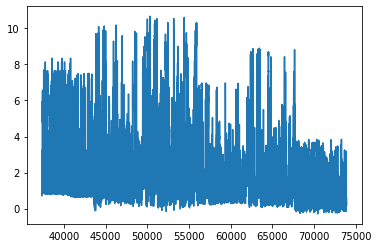

In [27]:
plt.plot(submission.index,submission['Production'])